In [ ]:
import os
import sys
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from datetime import datetime
from pathlib import Path
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.patches import Rectangle

import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
# set fonts configuration - Arial
matplotlib.rcParams['font.family'] = "Open Sans"
matplotlib.rcParams['font.sans-serif'] = "Arial"

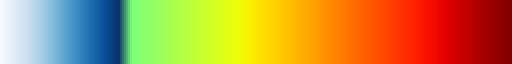

In [4]:
colors1 = plt.cm.Blues(np.linspace(0., 1, 10))
colors2 = plt.cm.jet(np.linspace(0.5, 1, 30))

# combine them and build a new colormap
colors = np.vstack((colors1, colors2))
mixedmap = LinearSegmentedColormap.from_list('my_colormap', colors)
mixedmap

In [24]:
# directory of the mcs_3dvars files

year = 2014
dir_envs_track = Path('/neelin2020/mcs_flextrkr/mcs_stats/envs_track/{}/totp_defined'.format(year))

files = sorted(list(dir_envs_track.glob('*.nc')))

# track data
data_tracks = xr.open_dataset('/neelin2020/mcs_flextrkr/mcs_stats/mcs_tracks_non2mcs_2014.IndoPacific.nc')

In [7]:
def BL_mcs_2dmap(fid_envs_track):
    """
    input: processed envs_track file containing MCS feature mask and 2D/3D variables on ERA-5 coordinates
    return BL componets within the tracked MCS feature
    """
    
    data = xr.open_dataset(fid_envs_track)
    BL_TOT = data.BL_TOT
    BL_CAPE = data.BL_CAPE
    BL_SUBSAT = data.BL_SUBSAT
    
    # maskout grids not covered by MCS 
    mcs_mask = data.cloudtracknumber_nomergesplit # binary mask
    BL_TOT_masked = BL_TOT.where(mcs_mask > 0)
    BL_CAPE_masked = BL_CAPE.where(mcs_mask > 0)
    BL_SUBSAT_masked = BL_SUBSAT.where(mcs_mask > 0)
    
    BL_TOT_env = BL_TOT.where(mcs_mask == 0)
    BL_CAPE_env = BL_CAPE.where(mcs_mask == 0)
    BL_SUBSAT_env = BL_SUBSAT.where(mcs_mask == 0)
    
    return BL_TOT_masked, BL_CAPE_masked, BL_SUBSAT_masked, BL_TOT_env, BL_CAPE_env, BL_SUBSAT_env

In [ ]:
def cape_subsat_hist(files):

    # bins for BL_CAPE and BL_SUBSAT
    bins_cape = np.linspace(-2,10,25)
    bins_subsat = np.linspace(-2,10,25)
    bins_samples = np.zeros((2, 5, len(bins_cape)-1, len(bins_subsat)-1)) # histograms for 5 MCS phases

    track_list = []
    for file in files:
        
        track_list.append(int(file.name[-8:-3])) # save track number 
        
        (BL_TOT, BL_CAPE, BL_SUBSAT, BL_TOT_env, BL_CAPE_env, BL_SUBSAT_env) = BL_mcs_2dmap(file)

        for p, phase in enumerate(["Init", "Grow", "Mature", "Decay", "End"]):

            wb = 0.4
            wl = 0.6
            thetae_ref = 340

            # ===== for inside mcs ======
            BL_CAPE_phase = BL_CAPE.sel(mcs_phase=phase) # 9.81*(wb*(thetae_bl-thetae_sat_lt)/thetae_sat_lt)
            BL_CAPE_phase = BL_CAPE_phase/9.81/wb*thetae_ref
            BL_SUBSAT_phase = BL_SUBSAT.sel(mcs_phase=phase) # 9.81*(wl*(thetae_sat_lt-thetae_lt)/thetae_sat_lt)
            BL_SUBSAT_phase = BL_SUBSAT_phase/9.81/wl*thetae_ref

            # get 1-D CAPE and SUBSAT values associated with MCS
            cape_1d = np.unique(BL_CAPE_phase)[:-1] # the last one is NaN
            subsat_1d = np.unique(BL_SUBSAT_phase)[:-1] # the last one is NaN 

            for i in range(len(bins_cape)-1):
                idx = np.where(np.logical_and(cape_1d >= bins_cape[i], cape_1d < bins_cape[i+1]))[0]
                for j in range(len(bins_subsat)-1):
                    idy = np.where(np.logical_and(subsat_1d >= bins_subsat[j], subsat_1d < bins_subsat[j+1]))[0]

                    idx_com = np.intersect1d(idx,idy)
                    bins_samples[0,p,i,j] += len(idx_com)

            # ===== for outside mcs (environment) ======
            BL_CAPE_phase_env = BL_CAPE_env.sel(mcs_phase=phase) # 9.81*(wb*(thetae_bl-thetae_sat_lt)/thetae_sat_lt)
            BL_CAPE_phase_env = BL_CAPE_phase_env/9.81/wb*thetae_ref
            BL_SUBSAT_phase_env = BL_SUBSAT_env.sel(mcs_phase=phase) # 9.81*(wl*(thetae_sat_lt-thetae_lt)/thetae_sat_lt)
            BL_SUBSAT_phase_env = BL_SUBSAT_phase_env/9.81/wl*thetae_ref

            # get 1-D CAPE and SUBSAT values associated with the environment
            cape_1d = np.unique(BL_CAPE_phase_env)[:-1] # the last one is NaN
            subsat_1d = np.unique(BL_SUBSAT_phase_env)[:-1] # the last one is NaN 

            for i in range(len(bins_cape)-1):
                idx = np.where(np.logical_and(cape_1d >= bins_cape[i], cape_1d < bins_cape[i+1]))[0]
                for j in range(len(bins_subsat)-1):
                    idy = np.where(np.logical_and(subsat_1d >= bins_subsat[j], subsat_1d < bins_subsat[j+1]))[0]

                    idx_com = np.intersect1d(idx,idy)
                    bins_samples[1,p,i,j] += len(idx_com)
                    
    ds_bins = xr.Dataset(data_vars = dict(samples = (['area','phase','bins_cape','bins_subsat'], bins_samples)),
                 coords = dict(tracks = track_list,
                               area = (['area'],['mcs','env']),
                               phase = (['phase'], ['Initial', 'Grow', 'Mature', 'Decay', 'End']),
                               bins_cape = (['bins_cape'], bins_cape[:-1]),
                               bins_subsat = (['bins_subsat'], bins_subsat[:-1])),
                 attrs = dict(description = 'cape-subsat histogram. 2014'))
    
    return ds_bins

In [83]:
def cape_subsat_condmn(files):

    # bins for BL_CAPE and BL_SUBSAT
    bins_cape = np.linspace(-2,10,25)
    bins_subsat = np.linspace(-2,10,25)
    bins_samples = np.zeros((2, 5, len(bins_cape)-1, len(bins_subsat)-1)) # histograms for 5 MCS phases

    track_list = []
    for file in files:
        
        track_list.append(int(file.name[-8:-3])) # save track number 
        
        (BL_TOT, BL_CAPE, BL_SUBSAT, BL_TOT_env, BL_CAPE_env, BL_SUBSAT_env) = BL_mcs_2dmap(file)

        for p, phase in enumerate(["Init", "Grow", "Mature", "Decay", "End"]):

            wb = 0.4
            wl = 0.6
            thetae_ref = 340

            # ===== for inside mcs ======
            BL_CAPE_phase = BL_CAPE.sel(mcs_phase=phase) # 9.81*(wb*(thetae_bl-thetae_sat_lt)/thetae_sat_lt)
            BL_CAPE_phase = BL_CAPE_phase/9.81/wb*thetae_ref
            BL_SUBSAT_phase = BL_SUBSAT.sel(mcs_phase=phase) # 9.81*(wl*(thetae_sat_lt-thetae_lt)/thetae_sat_lt)
            BL_SUBSAT_phase = BL_SUBSAT_phase/9.81/wl*thetae_ref

            # get 1-D CAPE and SUBSAT values associated with MCS
            cape_1d = np.unique(BL_CAPE_phase)[:-1] # the last one is NaN
            subsat_1d = np.unique(BL_SUBSAT_phase)[:-1] # the last one is NaN 

            for i in range(len(bins_cape)-1):
                idx = np.where(np.logical_and(cape_1d >= bins_cape[i], cape_1d < bins_cape[i+1]))[0]
                for j in range(len(bins_subsat)-1):
                    idy = np.where(np.logical_and(subsat_1d >= bins_subsat[j], subsat_1d < bins_subsat[j+1]))[0]

                    idx_com = np.intersect1d(idx,idy)
                    bins_samples[0,p,i,j] += len(idx_com)

            # ===== for outside mcs (environment) ======
            BL_CAPE_phase_env = BL_CAPE_env.sel(mcs_phase=phase) # 9.81*(wb*(thetae_bl-thetae_sat_lt)/thetae_sat_lt)
            BL_CAPE_phase_env = BL_CAPE_phase_env/9.81/wb*thetae_ref
            BL_SUBSAT_phase_env = BL_SUBSAT_env.sel(mcs_phase=phase) # 9.81*(wl*(thetae_sat_lt-thetae_lt)/thetae_sat_lt)
            BL_SUBSAT_phase_env = BL_SUBSAT_phase_env/9.81/wl*thetae_ref

            # get 1-D CAPE and SUBSAT values associated with the environment
            cape_1d = np.unique(BL_CAPE_phase_env)[:-1] # the last one is NaN
            subsat_1d = np.unique(BL_SUBSAT_phase_env)[:-1] # the last one is NaN 

            for i in range(len(bins_cape)-1):
                idx = np.where(np.logical_and(cape_1d >= bins_cape[i], cape_1d < bins_cape[i+1]))[0]
                for j in range(len(bins_subsat)-1):
                    idy = np.where(np.logical_and(subsat_1d >= bins_subsat[j], subsat_1d < bins_subsat[j+1]))[0]

                    idx_com = np.intersect1d(idx,idy)
                    bins_samples[1,p,i,j] += len(idx_com)
                    
    ds_bins = xr.Dataset(data_vars = dict(samples = (['area','phase','bins_cape','bins_subsat'], bins_samples)),
                 coords = dict(tracks = track_list,
                               area = (['area'],['mcs','env']),
                               phase = (['phase'], ['Initial', 'Grow', 'Mature', 'Decay', 'End']),
                               bins_cape = (['bins_cape'], bins_cape[:-1]),
                               bins_subsat = (['bins_subsat'], bins_subsat[:-1])),
                 attrs = dict(description = 'cape-subsat histogram. 2014'))
    
    return ds_bins

In [100]:
tmp = data_tracks.mcs_duration
tracks_short = tmp.isel(tracks=np.where(tmp < 12)[0]).tracks
tracks_long = tmp.isel(tracks=np.where(tmp > 24)[0]).tracks

In [147]:
%%time
# creating file lists for different categories

files_short = []
for track in tracks_short:
    if len(list(dir_envs_track.glob('*{}.nc'.format(str(track.values).zfill(5))))) == 1:
        files_short.extend(list(dir_envs_track.glob('*{}*.nc'.format(str(track.values).zfill(5)))))
    
files_long = []
for track in tracks_long:
    if len(list(dir_envs_track.glob('*{}.nc'.format(str(track.values).zfill(5))))) == 1:
        files_long.extend(dir_envs_track.glob('*{}*.nc'.format(str(track.values).zfill(5))))
    
ds_cape_sub_short = cape_subsat_hist(files_short)
ds_cape_sub_long = cape_subsat_hist(files_long)

CPU times: user 1min 42s, sys: 2.27 s, total: 1min 45s
Wall time: 1min 46s


Text(0.5, 1.05, 'Buoyancy CAPE-SUBSAT histogram at MCS phases (716)')

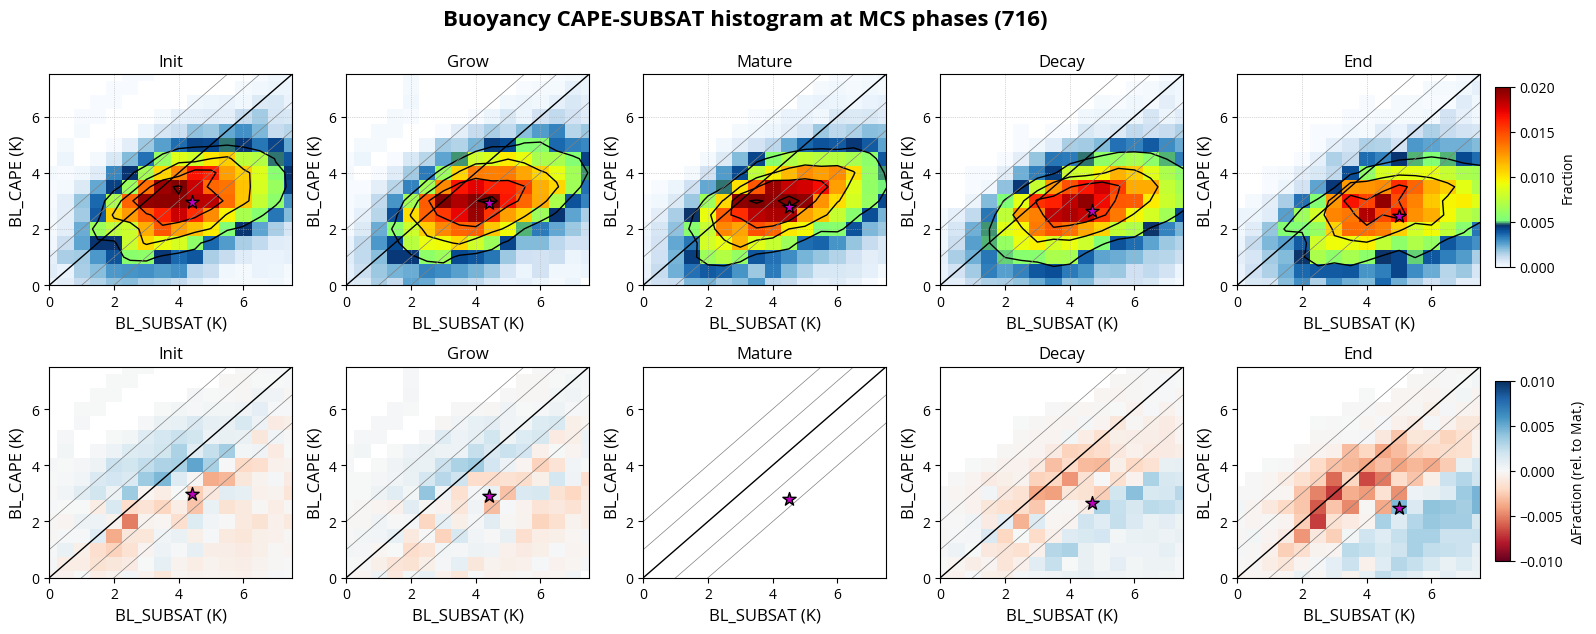

In [151]:
# read written output
data_bins = ds_cape_sub_short
bins_cape = data_bins.bins_cape
bins_subsat = data_bins.bins_subsat
bins_sample = data_bins.sel(area='mcs').samples.values

# plot histogram : fraction of occurrences at different MCS phases

fig, ((ax1,ax2,ax3,ax4,ax5),(ax6,ax7,ax8,ax9,ax10)) = plt.subplots(2,5,figsize=(15,6))

for n, (mcs_phase,ax) in enumerate(zip(['Init','Grow','Mature','Decay','End'],[ax1,ax2,ax3,ax4,ax5])):
    
    tmp = bins_sample[n,:,:]/np.sum(bins_sample[n,:,:])
    tmp[tmp == 0] = np.nan
    
    cp = ax.pcolormesh(bins_subsat, bins_cape, tmp,
                    vmin=0, vmax=0.02, cmap=mixedmap)
    
    # contour: fraction of occurrence
    ax.contour(bins_subsat, bins_cape, tmp,
              levels=[0.005, 0.01, 0.015, 0.02], colors=['k'], linewidths=1)
    
    if n == 4:
        caxes = fig.add_axes([1, 0.62, 0.01, 0.3])
        cbar = plt.colorbar(cp, cax=caxes)
        cbar.set_label('Fraction')
    ax.set_title(mcs_phase)
    ax.set_xlabel('BL_SUBSAT (K)',fontsize=12)
    ax.set_ylabel('BL_CAPE (K)',fontsize=12)    
    ax.set_ylim([0, 7.5])
    ax.set_xlim([0, 7.5])
    
    # buoyancy reference lines
    ax.plot(np.linspace(-2,10,13), np.linspace(-2,10,13), marker=None, color='k',zorder=2, linewidth=1) # zero buoyancy
    ax.plot(np.linspace(-2,10,13), np.linspace(-2,10,13)+2, marker=None, color='grey',zorder=2, linewidth=0.5) # +2 K 
    ax.plot(np.linspace(-2,10,13), np.linspace(-2,10,13)+1, marker=None, color='grey',zorder=2, linewidth=0.5) # +1 K 
    ax.plot(np.linspace(-2,10,13), np.linspace(-2,10,13)-1, marker=None, color='grey',zorder=2, linewidth=0.5) # -1 K 
    ax.plot(np.linspace(-2,10,13), np.linspace(-2,10,13)-2, marker=None, color='grey',zorder=2, linewidth=0.5) # -2 K 

    ax.grid(linestyle=':', linewidth=0.5)
    
    # plot mean states of BL_CAPE and BL_SUBSAT
    mean_cape = np.sum(bins_cape*(np.sum(bins_sample[n,:,:],axis=1)/np.sum(bins_sample[n,:,:])))
    mean_subsat = np.sum(bins_subsat*(np.sum(bins_sample[n,:,:],axis=0)/np.sum(bins_sample[n,:,:])))
    ax.scatter(mean_subsat, mean_cape, s=100, marker='*', color='m', zorder=2, edgecolor='k')

for n, (mcs_phase,ax) in enumerate(zip(['Init','Grow','Mature','Decay','End'],[ax6,ax7,ax8,ax9,ax10])):
    
    tmp = bins_sample[n,:,:]/np.sum(bins_sample[n,:,:]) - bins_sample[2,:,:]/np.sum(bins_sample[2,:,:])
    tmp[tmp == 0] = np.nan
    
    cp = ax.pcolormesh(bins_subsat, bins_cape, tmp,
                    vmin=-0.01, vmax=0.01, cmap='RdBu')
    if n == 4:
        caxes = fig.add_axes([1, 0.13, 0.01, 0.3])
        cbar = plt.colorbar(cp, cax=caxes)
        cbar.set_label('$\Delta$Fraction (rel. to Mat.)')
    ax.set_title(mcs_phase)
    ax.set_xlabel('BL_SUBSAT (K)',fontsize=12)
    ax.set_ylabel('BL_CAPE (K)',fontsize=12)
    ax.set_ylim([0, 7.5])
    ax.set_xlim([0, 7.5])
    
    # buoyancy reference lines
    ax.plot(np.linspace(-2,10,13), np.linspace(-2,10,13), marker=None, color='k',zorder=2, linewidth=1) # zero buoyancy
    ax.plot(np.linspace(-2,10,13), np.linspace(-2,10,13)+2, marker=None, color='grey',zorder=2, linewidth=0.5) # +2 K 
    ax.plot(np.linspace(-2,10,13), np.linspace(-2,10,13)+1, marker=None, color='grey',zorder=2, linewidth=0.5) # +1 K 
    ax.plot(np.linspace(-2,10,13), np.linspace(-2,10,13)-1, marker=None, color='grey',zorder=2, linewidth=0.5) # -1 K 
    ax.plot(np.linspace(-2,10,13), np.linspace(-2,10,13)-2, marker=None, color='grey',zorder=2, linewidth=0.5) # -2 K 

    # plot mean states of BL_CAPE and BL_SUBSAT
    mean_cape = np.sum(bins_cape*(np.sum(bins_sample[n,:,:],axis=1)/np.sum(bins_sample[n,:,:])))
    mean_subsat = np.sum(bins_subsat*(np.sum(bins_sample[n,:,:],axis=0)/np.sum(bins_sample[n,:,:])))
    ax.scatter(mean_subsat, mean_cape, s=100, marker='*', color='m', zorder=2, edgecolor='k')
    
plt.tight_layout()
plt.suptitle('Buoyancy CAPE-SUBSAT histogram at MCS phases ({})'.format(len(ds_cape_sub_short.tracks)), fontsize=16, fontweight='bold', y=1.05)

Text(0.5, 1.05, 'Buoyancy CAPE-SUBSAT histogram at MCS phases (146)')

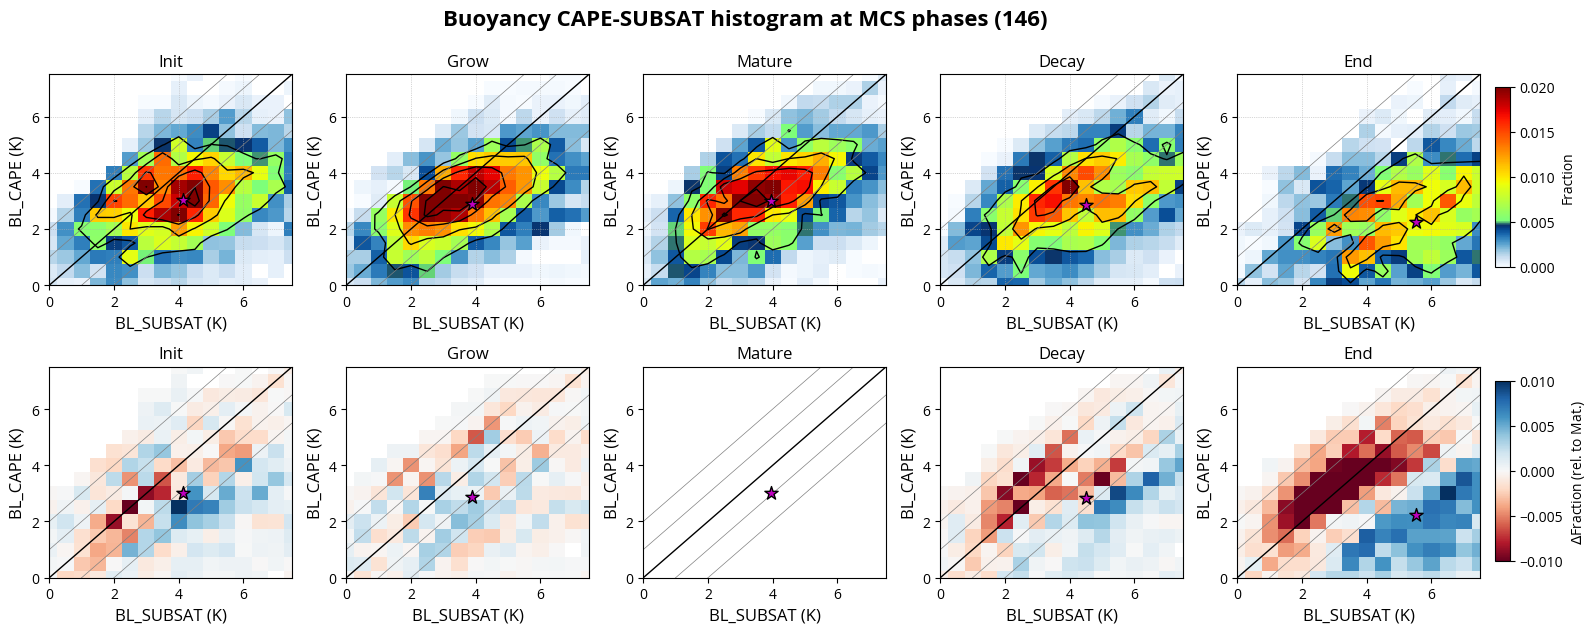

In [179]:
# read written output
data_bins = ds_cape_sub_long
bins_cape = data_bins.bins_cape
bins_subsat = data_bins.bins_subsat
bins_sample = data_bins.sel(area='mcs').samples.values

# plot histogram : fraction of occurrences at different MCS phases

fig, ((ax1,ax2,ax3,ax4,ax5),(ax6,ax7,ax8,ax9,ax10)) = plt.subplots(2,5,figsize=(15,6))

for n, (mcs_phase,ax) in enumerate(zip(['Init','Grow','Mature','Decay','End'],[ax1,ax2,ax3,ax4,ax5])):
    
    tmp = bins_sample[n,:,:]/np.sum(bins_sample[n,:,:])
    tmp[tmp == 0] = np.nan
    
    cp = ax.pcolormesh(bins_subsat, bins_cape, tmp,
                    vmin=0, vmax=0.02, cmap=mixedmap)
    
    # contour: fraction of occurrence
    ax.contour(bins_subsat, bins_cape, tmp,
              levels=[0.005, 0.01, 0.015, 0.02], colors=['k'], linewidths=1)
    
    if n == 4:
        caxes = fig.add_axes([1, 0.62, 0.01, 0.3])
        cbar = plt.colorbar(cp, cax=caxes)
        cbar.set_label('Fraction')
    ax.set_title(mcs_phase)
    ax.set_xlabel('BL_SUBSAT (K)',fontsize=12)
    ax.set_ylabel('BL_CAPE (K)',fontsize=12)    
    ax.set_ylim([0, 7.5])
    ax.set_xlim([0, 7.5])
    
    # buoyancy reference lines
    ax.plot(np.linspace(-2,10,13), np.linspace(-2,10,13), marker=None, color='k',zorder=2, linewidth=1) # zero buoyancy
    ax.plot(np.linspace(-2,10,13), np.linspace(-2,10,13)+2, marker=None, color='grey',zorder=2, linewidth=0.5) # +2 K 
    ax.plot(np.linspace(-2,10,13), np.linspace(-2,10,13)+1, marker=None, color='grey',zorder=2, linewidth=0.5) # +1 K 
    ax.plot(np.linspace(-2,10,13), np.linspace(-2,10,13)-1, marker=None, color='grey',zorder=2, linewidth=0.5) # -1 K 
    ax.plot(np.linspace(-2,10,13), np.linspace(-2,10,13)-2, marker=None, color='grey',zorder=2, linewidth=0.5) # -2 K 

    ax.grid(linestyle=':', linewidth=0.5)
    
    # plot mean states of BL_CAPE and BL_SUBSAT
    mean_cape = np.sum(bins_cape*(np.sum(bins_sample[n,:,:],axis=1)/np.sum(bins_sample[n,:,:])))
    mean_subsat = np.sum(bins_subsat*(np.sum(bins_sample[n,:,:],axis=0)/np.sum(bins_sample[n,:,:])))
    ax.scatter(mean_subsat, mean_cape, s=100, marker='*', color='m', zorder=2, edgecolor='k')

for n, (mcs_phase,ax) in enumerate(zip(['Init','Grow','Mature','Decay','End'],[ax6,ax7,ax8,ax9,ax10])):
    
    tmp = bins_sample[n,:,:]/np.sum(bins_sample[n,:,:]) - bins_sample[2,:,:]/np.sum(bins_sample[2,:,:])
    tmp[tmp == 0] = np.nan
    
    cp = ax.pcolormesh(bins_subsat, bins_cape, tmp,
                    vmin=-0.01, vmax=0.01, cmap='RdBu')
    if n == 4:
        caxes = fig.add_axes([1, 0.13, 0.01, 0.3])
        cbar = plt.colorbar(cp, cax=caxes)
        cbar.set_label('$\Delta$Fraction (rel. to Mat.)')
    ax.set_title(mcs_phase)
    ax.set_xlabel('BL_SUBSAT (K)',fontsize=12)
    ax.set_ylabel('BL_CAPE (K)',fontsize=12)
    ax.set_ylim([0, 7.5])
    ax.set_xlim([0, 7.5])
    
    # buoyancy reference lines
    ax.plot(np.linspace(-2,10,13), np.linspace(-2,10,13), marker=None, color='k',zorder=2, linewidth=1) # zero buoyancy
    ax.plot(np.linspace(-2,10,13), np.linspace(-2,10,13)+2, marker=None, color='grey',zorder=2, linewidth=0.5) # +2 K 
    ax.plot(np.linspace(-2,10,13), np.linspace(-2,10,13)+1, marker=None, color='grey',zorder=2, linewidth=0.5) # +1 K 
    ax.plot(np.linspace(-2,10,13), np.linspace(-2,10,13)-1, marker=None, color='grey',zorder=2, linewidth=0.5) # -1 K 
    ax.plot(np.linspace(-2,10,13), np.linspace(-2,10,13)-2, marker=None, color='grey',zorder=2, linewidth=0.5) # -2 K 

    # plot mean states of BL_CAPE and BL_SUBSAT
    mean_cape = np.sum(bins_cape*(np.sum(bins_sample[n,:,:],axis=1)/np.sum(bins_sample[n,:,:])))
    mean_subsat = np.sum(bins_subsat*(np.sum(bins_sample[n,:,:],axis=0)/np.sum(bins_sample[n,:,:])))
    ax.scatter(mean_subsat, mean_cape, s=100, marker='*', color='m', zorder=2, edgecolor='k')
    
plt.tight_layout()
plt.suptitle('Buoyancy CAPE-SUBSAT histogram at MCS phases ({})'.format(len(ds_cape_sub_long.tracks)), fontsize=16, fontweight='bold', y=1.05)

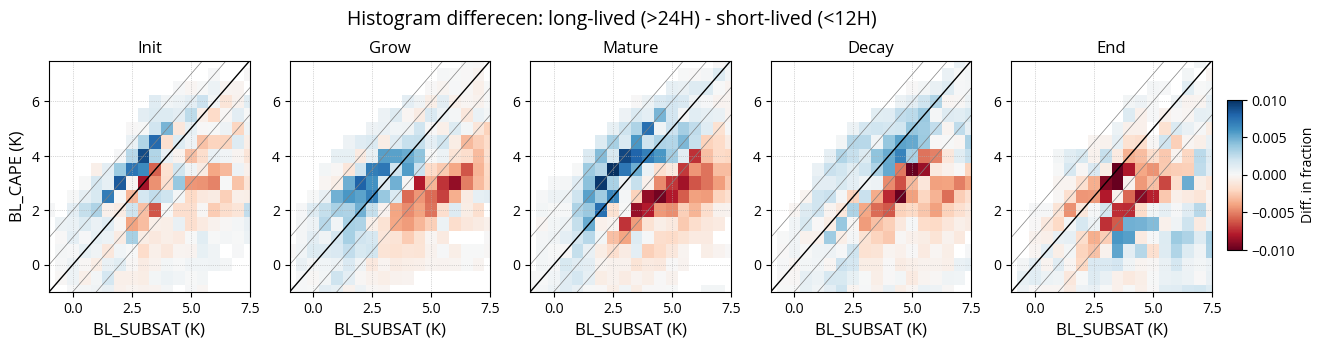

In [200]:
# difference between long-lived and short-lived MCSs
fig,(ax1,ax2,ax3,ax4,ax5) = plt.subplots(1,5,figsize=(15,3))

data_bin_s = ds_cape_sub_short
data_bin_l = ds_cape_sub_long

bins_cape = data_bins.bins_cape
bins_subsat = data_bins.bins_subsat
bins_sample_s = data_bin_s.sel(area='mcs').samples.values
bins_sample_l = data_bin_l.sel(area='mcs').samples.values

for n, (mcs_phase,ax) in enumerate(zip(['Init','Grow','Mature','Decay','End'],[ax1,ax2,ax3,ax4,ax5])):
    
    tmp1 = bins_sample_s[n,:,:]/np.sum(bins_sample_s[n,:,:])
    tmp1[tmp1 == 0] = np.nan
    tmp2 = bins_sample_l[n,:,:]/np.sum(bins_sample_l[n,:,:])
    tmp2[tmp2 == 0] = np.nan
    
    cp = ax.pcolormesh(bins_subsat, bins_cape, tmp2-tmp1,
                    vmin=-0.01, vmax=0.01, cmap='RdBu')
    
    # contour: fraction of occurrence
    #ax.contour(bins_subsat, bins_cape, tmp2-tmp,
    #          levels=[0.005, 0.01, 0.015, 0.02], colors=['k'], linewidths=1)
    
    if n == 4:
        caxes = fig.add_axes([0.91, 0.25, 0.01, 0.5])
        cbar = plt.colorbar(cp, cax=caxes)
        cbar.set_label('Diff. in fraction')
    ax.set_title(mcs_phase)
    ax.set_xlabel('BL_SUBSAT (K)',fontsize=12)
    ax.set_ylim([-1, 7.5])
    ax.set_xlim([-1, 7.5])
    
    if n == 0:
        ax.set_ylabel('BL_CAPE (K)',fontsize=12)    

    
    # buoyancy reference lines
    ax.plot(np.linspace(-2,10,13), np.linspace(-2,10,13), marker=None, color='k',zorder=2, linewidth=1) # zero buoyancy
    ax.plot(np.linspace(-2,10,13), np.linspace(-2,10,13)+2, marker=None, color='grey',zorder=2, linewidth=0.5) # +2 K 
    ax.plot(np.linspace(-2,10,13), np.linspace(-2,10,13)+1, marker=None, color='grey',zorder=2, linewidth=0.5) # +1 K 
    ax.plot(np.linspace(-2,10,13), np.linspace(-2,10,13)-1, marker=None, color='grey',zorder=2, linewidth=0.5) # -1 K 
    ax.plot(np.linspace(-2,10,13), np.linspace(-2,10,13)-2, marker=None, color='grey',zorder=2, linewidth=0.5) # -2 K 

    ax.grid(linestyle=':', linewidth=0.5)
    
plt.suptitle('Histogram differecen: long-lived (>24H) - short-lived (<12H)',fontsize=14, y=1.05);

In [60]:
# %%time
# bins_cape = np.linspace(0,8,17)
# bins_subsat = np.linspace(0,8,17)
# bins_samples = np.zeros((4, len(bins_cape)-1, len(bins_subsat)-1))
# bins_duration_sum = np.copy(bins_samples)

# for p,phase in enumerate(['Init','Grow','Mature','Decay']):
    
#     cape_list = []
#     subsat_list = []
#     duration_list = []
    
#     for n in range(len(files)):

#         (BL_TOT, BL_CAPE, BL_SUBSAT, BL_TOT_env, BL_CAPE_env, BL_SUBSAT_env) = BL_mcs_2dmap(files[n])

#         wb = 0.4
#         wl = 0.6
#         thetae_ref = 340

#         cape_list.append(BL_CAPE.sel(mcs_phase=phase).mean()/9.81/wb*thetae_ref)
#         subsat_list.append(BL_SUBSAT.sel(mcs_phase=phase).mean()/9.81/wl*thetae_ref)
#         duration_list.append(data_tracks.sel(tracks=int(files[n].name[-8:-3])).mcs_duration)
    
#     # binning 
#     cape_1d = np.asarray(cape_list)
#     subsat_1d = np.asarray(subsat_list)
#     duration_1d = np.asarray(duration_list)
    
#     for i in range(len(bins_cape)-1):
#         idx = np.where(np.logical_and(cape_1d >= bins_cape[i], cape_1d < bins_cape[i+1]))[0]
#         for j in range(len(bins_subsat)-1):
#             idy = np.where(np.logical_and(subsat_1d >= bins_subsat[j], subsat_1d < bins_subsat[j+1]))[0]

#             idx_com = np.intersect1d(idx,idy)
#             bins_samples[p,i,j] += len(idx_com) 
#             bins_duration_sum[p,i,j] += np.sum(duration_1d[idx_com])

CPU times: user 1min 53s, sys: 5.43 s, total: 1min 59s
Wall time: 2min 9s


In [65]:
ds_bins = xr.Dataset(data_vars = dict(samples = (['phase','bins_cape','bins_subsat'], bins_samples), 
                                      duration_sum = (['phase','bins_cape','bins_subsat'], bins_duration_sum)),                                     
                     coords = dict(phase = (['phase'], ['Initial', 'Grow', 'Mature', 'Decay']),
                                   bins_cape = (['bins_cape'], bins_cape[:-1]),
                                   bins_subsat = (['bins_subsat'], bins_subsat[:-1])))

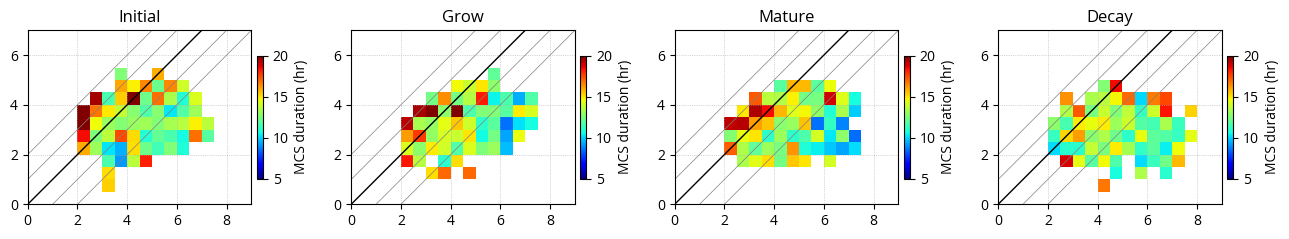

In [74]:
fig,ax = plt.subplots(1,4,figsize=(16,4))

for p,phase in enumerate(ds_bins.phase.values):

    duration = ds_bins.isel(phase=p).duration_sum
    samples = ds_bins.isel(phase=p).samples
    duration_mean = duration/samples
    duration_mean_mask = duration_mean.where(samples > 5) # screen out bins with fewer samples
    
    cp = ax[p].pcolormesh(bins_subsat, bins_cape, duration_mean_mask,
                          cmap='jet', vmin=5, vmax=20)
    cbar = plt.colorbar(cp, ax=ax[p], shrink=0.4, pad=0.02)
    cbar.set_label('MCS duration (hr)')
    
    # buoyancy reference lines
    ax[p].plot(np.linspace(-2,10,13), np.linspace(-2,10,13), marker=None, color='k',zorder=2, linewidth=1) # zero buoyancy
    ax[p].plot(np.linspace(-2,10,13), np.linspace(-2,10,13)+2, marker=None, color='grey',zorder=2, linewidth=0.5) # +2 K 
    ax[p].plot(np.linspace(-2,10,13), np.linspace(-2,10,13)+1, marker=None, color='grey',zorder=2, linewidth=0.5) # +1 K 
    ax[p].plot(np.linspace(-2,10,13), np.linspace(-2,10,13)-1, marker=None, color='grey',zorder=2, linewidth=0.5) # -1 K 
    ax[p].plot(np.linspace(-2,10,13), np.linspace(-2,10,13)-2, marker=None, color='grey',zorder=2, linewidth=0.5) # -2 K     
    
    ax[p].set_ylim([0,7])
    ax[p].set_xlim([0,9])
    ax[p].grid(linestyle=':', linewidth=0.5)
    ax[p].set_aspect('equal', 'box')
    ax[p].set_title(phase)

In [ ]:
%%time

# bins for BL_CAPE and BL_SUBSAT

bins_cape = np.linspace(-2,10,25)
bins_subsat = np.linspace(-2,10,25)
bins_samples = np.zeros((2, 5, len(bins_cape)-1, len(bins_subsat)-1)) # histograms for 5 MCS phases

for file in files:
        
    (BL_TOT, BL_CAPE, BL_SUBSAT, BL_TOT_env, BL_CAPE_env, BL_SUBSAT_env) = BL_mcs_2dmap(file)

    for p, phase in enumerate(["Init", "Grow", "Mature", "Decay", "End"]):

        wb = 0.4
        wl = 0.6
        thetae_ref = 340
        
        # ===== for inside mcs ======
        BL_CAPE_phase = BL_CAPE.sel(mcs_phase=phase) # 9.81*(wb*(thetae_bl-thetae_sat_lt)/thetae_sat_lt)
        BL_CAPE_phase = BL_CAPE_phase/9.81/wb*thetae_ref
        BL_SUBSAT_phase = BL_SUBSAT.sel(mcs_phase=phase) # 9.81*(wl*(thetae_sat_lt-thetae_lt)/thetae_sat_lt)
        BL_SUBSAT_phase = BL_SUBSAT_phase/9.81/wl*thetae_ref
        
        # get 1-D CAPE and SUBSAT values associated with MCS
        cape_1d = np.unique(BL_CAPE_phase)[:-1] # the last one is NaN
        subsat_1d = np.unique(BL_SUBSAT_phase)[:-1] # the last one is NaN 

        for i in range(len(bins_cape)-1):
            idx = np.where(np.logical_and(cape_1d >= bins_cape[i], cape_1d < bins_cape[i+1]))[0]
            for j in range(len(bins_subsat)-1):
                idy = np.where(np.logical_and(subsat_1d >= bins_subsat[j], subsat_1d < bins_subsat[j+1]))[0]

                idx_com = np.intersect1d(idx,idy)
                bins_samples[0,p,i,j] += len(idx_com)
                
        # ===== for outside mcs (environment) ======
        BL_CAPE_phase_env = BL_CAPE_env.sel(mcs_phase=phase) # 9.81*(wb*(thetae_bl-thetae_sat_lt)/thetae_sat_lt)
        BL_CAPE_phase_env = BL_CAPE_phase_env/9.81/wb*thetae_ref
        BL_SUBSAT_phase_env = BL_SUBSAT_env.sel(mcs_phase=phase) # 9.81*(wl*(thetae_sat_lt-thetae_lt)/thetae_sat_lt)
        BL_SUBSAT_phase_env = BL_SUBSAT_phase_env/9.81/wl*thetae_ref
                
        # get 1-D CAPE and SUBSAT values associated with the environment
        cape_1d = np.unique(BL_CAPE_phase_env)[:-1] # the last one is NaN
        subsat_1d = np.unique(BL_SUBSAT_phase_env)[:-1] # the last one is NaN 
                
        for i in range(len(bins_cape)-1):
            idx = np.where(np.logical_and(cape_1d >= bins_cape[i], cape_1d < bins_cape[i+1]))[0]
            for j in range(len(bins_subsat)-1):
                idy = np.where(np.logical_and(subsat_1d >= bins_subsat[j], subsat_1d < bins_subsat[j+1]))[0]

                idx_com = np.intersect1d(idx,idy)
                bins_samples[1,p,i,j] += len(idx_com)

In [ ]:
# save bins into netcdf
dir_out = Path('/neelin2020/mcs_flextrkr/mcs_stats/output_stats')
ds_bins = xr.Dataset(data_vars = dict(samples = (['area','phase','bins_cape','bins_subsat'], bins_samples)),
                     coords = dict(area = (['area'],['mcs','env']),
                                   phase = (['phase'], ['Initial', 'Grow', 'Mature', 'Decay', 'End']),
                                   bins_cape = (['bins_cape'], bins_cape[:-1]),
                                   bins_subsat = (['bins_subsat'], bins_subsat[:-1])),
                     attrs = dict(description = 'cape-subsat histogram. 2014'))
ds_bins.to_netcdf(dir_out / 'mcs_cape_subsat_histogram_IndoPacific.nc')

In [ ]:
# read written output
data_bins = xr.open_dataset(dir_out /  'mcs_cape_subsat_histogram_IndoPacific.nc')
bins_cape = data_bins.bins_cape
bins_subsat = data_bins.bins_subsat
bins_sample = data_bins.sel(area='mcs').samples.values

# plot histogram : fraction of occurrences at different MCS phases

fig, ((ax1,ax2,ax3,ax4,ax5),(ax6,ax7,ax8,ax9,ax10)) = plt.subplots(2,5,figsize=(15,6))

for n, (mcs_phase,ax) in enumerate(zip(['Init','Grow','Mature','Decay','End'],[ax1,ax2,ax3,ax4,ax5])):
    
    tmp = bins_sample[n,:,:]/np.sum(bins_sample[n,:,:])
    tmp[tmp == 0] = np.nan
    
    cp = ax.pcolormesh(bins_subsat, bins_cape, tmp,
                    vmin=0, vmax=0.02, cmap=mixedmap)
    
    # contour: fraction of occurrence
    ax.contour(bins_subsat, bins_cape, tmp,
              levels=[0.005, 0.01, 0.015, 0.02], colors=['k'], linewidths=1)
    
    if n == 4:
        caxes = fig.add_axes([1, 0.62, 0.01, 0.3])
        cbar = plt.colorbar(cp, cax=caxes)
        cbar.set_label('Fraction')
    ax.set_title(mcs_phase)
    ax.set_xlabel('BL_SUBSAT (K)',fontsize=12)
    ax.set_ylabel('BL_CAPE (K)',fontsize=12)    
    ax.set_ylim([0, 7.5])
    ax.set_xlim([0, 7.5])
    
    # buoyancy reference lines
    ax.plot(np.linspace(-2,10,13), np.linspace(-2,10,13), marker=None, color='k',zorder=2, linewidth=1) # zero buoyancy
    ax.plot(np.linspace(-2,10,13), np.linspace(-2,10,13)+2, marker=None, color='grey',zorder=2, linewidth=0.5) # +2 K 
    ax.plot(np.linspace(-2,10,13), np.linspace(-2,10,13)+1, marker=None, color='grey',zorder=2, linewidth=0.5) # +1 K 
    ax.plot(np.linspace(-2,10,13), np.linspace(-2,10,13)-1, marker=None, color='grey',zorder=2, linewidth=0.5) # -1 K 
    ax.plot(np.linspace(-2,10,13), np.linspace(-2,10,13)-2, marker=None, color='grey',zorder=2, linewidth=0.5) # -2 K 

    ax.grid(linestyle=':', linewidth=0.5)
    
    # plot mean states of BL_CAPE and BL_SUBSAT
    mean_cape = np.sum(bins_cape*(np.sum(bins_sample[n,:,:],axis=1)/np.sum(bins_sample[n,:,:])))
    mean_subsat = np.sum(bins_subsat*(np.sum(bins_sample[n,:,:],axis=0)/np.sum(bins_sample[n,:,:])))
    ax.scatter(mean_subsat, mean_cape, s=100, marker='*', color='m', zorder=2, edgecolor='k')

for n, (mcs_phase,ax) in enumerate(zip(['Init','Grow','Mature','Decay','End'],[ax6,ax7,ax8,ax9,ax10])):
    
    tmp = bins_sample[n,:,:]/np.sum(bins_sample[n,:,:]) - bins_sample[2,:,:]/np.sum(bins_sample[2,:,:])
    tmp[tmp == 0] = np.nan
    
    cp = ax.pcolormesh(bins_subsat, bins_cape, tmp,
                    vmin=-0.01, vmax=0.01, cmap='RdBu')
    if n == 4:
        caxes = fig.add_axes([1, 0.13, 0.01, 0.3])
        cbar = plt.colorbar(cp, cax=caxes)
        cbar.set_label('$\Delta$Fraction (rel. to Mat.)')
    ax.set_title(mcs_phase)
    ax.set_xlabel('BL_SUBSAT (K)',fontsize=12)
    ax.set_ylabel('BL_CAPE (K)',fontsize=12)
    ax.set_ylim([0, 7.5])
    ax.set_xlim([0, 7.5])
    
    # buoyancy reference lines
    ax.plot(np.linspace(-2,10,13), np.linspace(-2,10,13), marker=None, color='k',zorder=2, linewidth=1) # zero buoyancy
    ax.plot(np.linspace(-2,10,13), np.linspace(-2,10,13)+2, marker=None, color='grey',zorder=2, linewidth=0.5) # +2 K 
    ax.plot(np.linspace(-2,10,13), np.linspace(-2,10,13)+1, marker=None, color='grey',zorder=2, linewidth=0.5) # +1 K 
    ax.plot(np.linspace(-2,10,13), np.linspace(-2,10,13)-1, marker=None, color='grey',zorder=2, linewidth=0.5) # -1 K 
    ax.plot(np.linspace(-2,10,13), np.linspace(-2,10,13)-2, marker=None, color='grey',zorder=2, linewidth=0.5) # -2 K 

    # plot mean states of BL_CAPE and BL_SUBSAT
    mean_cape = np.sum(bins_cape*(np.sum(bins_sample[n,:,:],axis=1)/np.sum(bins_sample[n,:,:])))
    mean_subsat = np.sum(bins_subsat*(np.sum(bins_sample[n,:,:],axis=0)/np.sum(bins_sample[n,:,:])))
    ax.scatter(mean_subsat, mean_cape, s=100, marker='*', color='m', zorder=2, edgecolor='k')
    
plt.tight_layout()
plt.suptitle('Buoyancy CAPE-SUBSAT histogram at MCS phases', fontsize=16, fontweight='bold', y=1.05)